In [1]:
import os

import schematics as scm
import schematics.types as scmt

import pandas as pd
import numpy as np
import tensorboard.notebook as tbnb
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfl
import tensorflow.keras.preprocessing as tfpp
import tensorflow.data as tfd
import plotly.express as px

%cd ~/flatiron/python
import flatiron.core.tools as fict
import flatiron.core.dataset as ficd
import flatiron.core.logging as ficl
import flatiron.models.unet as fimu
import flatiron.core.pipeline as ficp

tf.get_logger().setLevel('ERROR')

2023-02-15 21:19:37.258955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 21:19:38.132363: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/targets/x86_64-linux/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-15 21:19:38.132456: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory

/home/ubuntu/flatiron/python


In [41]:
with open('../resources/slack-url.txt') as f:
    url = f.read().strip('\n')
config = f'''
model:
    input_width: 208
    input_height: 208
    input_channels: 3
    classes: 1
    filters: 64
    layers: 9
    activation: leaky_relu
    batch_norm: true
    output_activation: sigmoid
    # kernel_initializer:
    attention_gates: true
    # attention_activation_1:
    # attention_activation_2:
    # attention_kernel_size:
    # attention_strides:
    # attention_padding:
    # attention_kernel_initializer:
dataset:
    source: /mnt/storage/projects/unet001/dset001/p-unet001_s-dset001_d-glom_v001
    split_index: -1
    load_limit: 100
preprocess:
    name: identity
optimizer:
    name: sgd
    learning_rate: 0.015
    momentum: 0.99
compile:
    loss: jaccard_loss
    metrics:
        - jaccard
        - dice
callbacks:
    project: unet001
    root: /mnt/storage/projects
fit:
    batch_size: 32
    validation_split: 0.1
logger:
    timezone: 'America/Los_Angeles'
    slack_url: '{url}'
    slack_channel: dev
    slack_methods: []
'''
# pipe = fimu.UNetPipeline \
#     .from_string(config) \
#     .load() \
#     .xy_split()

pipe = fimu.UNetPipeline \
    .from_string(config) \
    .load()
    # .train_test_split() \
    # .unload() \
    # .convert() \
    # .preprocess()
    # .xy_split() \
    # .unload() \
    # .build() \
    # .compile() \
    # .fit()

# pipe = fimu.UNetPipeline \
#     .from_string(config) \
#     .run()

May not total to 100% - Loading Dataset Chunks:   0%|          | 0/10 [00:00<?, ?it/s]

In [43]:
pipe.dataset.data.shape[0]

100

In [262]:
# preprocess = tfk.Sequential([
#     tfl.RandomFlip(seed=42),
#     # tfl.RandomRotation(0.2),
#     # tfl.RandomTranslation(0.1, 0.1),
# ])

def preprocess(data, seed=42):
    x = data['x_train']
    y = data['y_train']
    x = tf.image.random_flip_left_right(x, seed=seed)
    y = tf.image.random_flip_left_right(y, seed=seed)
    x = tf.image.random_flip_up_down(x, seed=seed)
    y = tf.image.random_flip_up_down(y, seed=seed)
    return dict(
        x_train=x,
        y_train=y,
    )

dset = tfd.Dataset \
    .from_tensor_slices(dict(
        x_train=pipe.x_train,
        y_train=pipe.y_train,
    )) \
    .batch(32) \
    .map(preprocess)

# x = dset \
#     .map(lambda x: fict.split_tensor(x, 3, -1, 'left')) \
#     .as_numpy_iterator()

# y = dset \
#     .map(lambda x: fict.split_tensor(x, 3, -1, 'right')) \
#     .as_numpy_iterator()

In [263]:
for datum in dset:
    x = datum['x_train']
    y = datum['y_train']
    break

In [264]:
i = 0

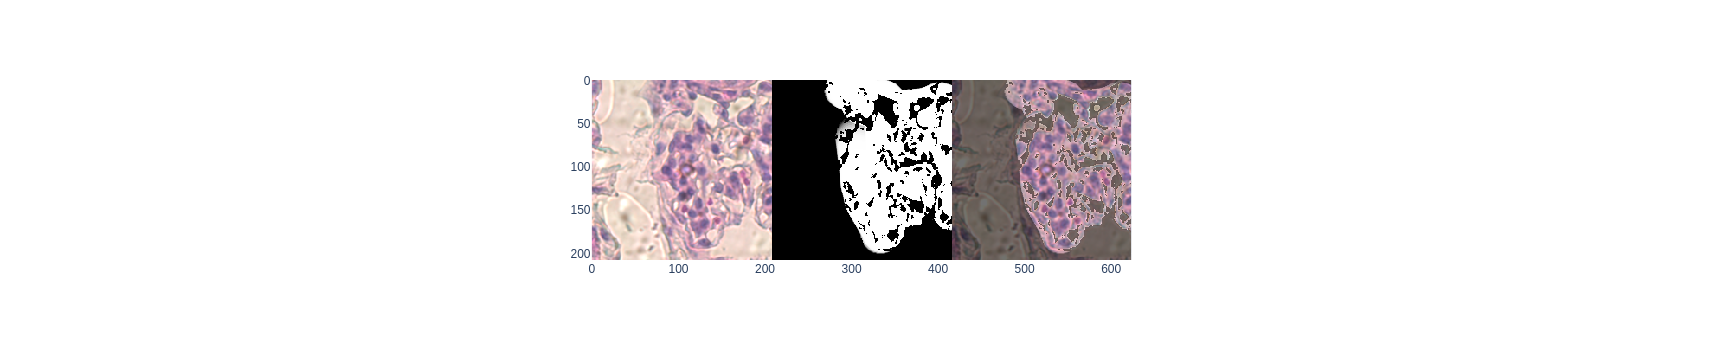

In [286]:
x0 = x[i]
y0 = y[i]

y0 = np.concatenate([y0, y0, y0], axis=2)
a0 = np.concatenate([x0, y0], axis=1)
a1 = x0 * (y0 * 0.5 + 0.45)
a2 = np.concatenate([a0, a1], axis=1)
i += 1
px.imshow(a2)

In [191]:
x0 = next(x)[0]
px.imshow(x0)

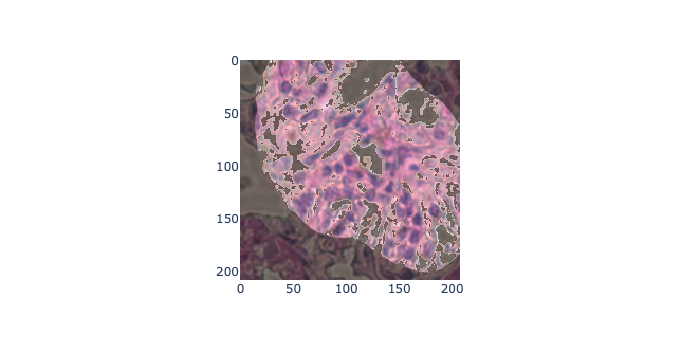

In [5]:
y0 = next(y)[0]
# px.imshow(np.squeeze(y0))

a0 = x0 * (y0 * 0.5 + 0.45)
px.imshow(a0)

In [11]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2023-02-15 03:23:24.019668: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /home/ubuntu/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteLK56ZG/oxford_iiit_pet-train.tfreco…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /home/ubuntu/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteLK56ZG/oxford_iiit_pet-test.tfrecor…

Dataset oxford_iiit_pet downloaded and prepared to /home/ubuntu/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [28]:
d = dataset['train']
d.from_tensors(
# d.element_spec
# q = d.map(lambda x: x)

<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [30]:
dset

TensorSpec(shape=(None, 208, 208, 4), dtype=tf.float32, name=None)